# Задание 5. Обучение без учителя

- [x] Найти данные с количеством признаков хотя бы 50, на которых можно решить задачу кластеризации.
- [x] Выполнить разведочный анализ (**EDA**). При необходимости выполнить полезные преобразования данных.
- [ ] Самостоятельно реализуйте один из алгоритмов кластеризации, например **K-means**.
- [ ] Обучите модели кластеризации, используя свою реализацию, а также хотя бы две реализации из **sklearn** (**KMeans**, **Affinity Propogation**, **DBSCAN** и тд).
- [x] При обучении использовать **подбор гиперпараметров**.
- [ ] Сравнить качество моделей: замерить скорость обучения, вычислить различные метрики качества.
- [ ] * (**+3 балла**) Также снизить размерность данных с помощью метода главных компонент **PCA** и и понять качество дальнейшей кластеризации всеми использованными реализациями при различном количестве главных компонент.
- [ ] * (**+2 балла**) Визуализировать данные снижением размерности до 2 или 3 с помощью **PCA** и **t-SNE**. В случае проблем с производительностью **t-SNE**, можно сначала до какой то степени снизить размерность с помощью **PCA**, а затем запустить **t-SNE**.

## Описание датасета
[Big Five Personality Dataset](https://www.kaggle.com/datasets/tunguz/big-five-personality-test/data) — содержит 1 015 342 ответа на анкеты и 110 признаков, учитывающих как сам ответ, так и сторонние показатели.

Для каждого вопроса была создана шкала ответов от 1 до 5, где 1 = не согласен, 3 = нейтрально, 5 = согласен. Примеры вопросов: "Я душа компании", "Я часто сочувствую другим людям", "Я стараюсь по возможности уклоняться от своих обязанностей". Некоторые вопросы противоречат другим, чтобы была возможность выявлять нечестные ответы.

В датасет также занесено время, потраченное на каждый вопрос, записанное в миллисекундах, страна проживания испытуемого и некоторое другие данные.

In [ ]:
import kagglehub
import pandas as pd
from pandas import DataFrame
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from scipy.spatial import distance
from sklearn.metrics import adjusted_rand_score, silhouette_score

## EDA

In [ ]:
folder = kagglehub.dataset_download("tunguz/big-five-personality-test")
dataset_path = os.path.join(folder, "IPIP-FFM-data-8Nov2018", "data-final.csv")

df = pd.read_csv(dataset_path, sep="\t")

df.tail(2)

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,...,dateload,screenw,screenh,introelapse,testelapse,endelapse,IPC,country,lat_appx_lots_of_err,long_appx_lots_of_err
1015339,2.0,4.0,3.0,4.0,2.0,2.0,1.0,4.0,2.0,4.0,...,2018-11-08 12:08:34,1920.0,1080.0,6.0,212.0,8,1,US,34.1067,-117.8067
1015340,4.0,2.0,4.0,2.0,4.0,1.0,4.0,2.0,4.0,4.0,...,2018-11-08 12:08:45,1920.0,1080.0,3.0,176.0,9,1,US,38.0,-97.0


In [74]:
df.dtypes

EXT1                     float64
EXT2                     float64
EXT3                     float64
EXT4                     float64
EXT5                     float64
                          ...   
endelapse                  int64
IPC                        int64
country                   object
lat_appx_lots_of_err      object
long_appx_lots_of_err     object
Length: 110, dtype: object

In [ ]:
# dateload    The timestamp when the survey was started.
# screenw     The width the of user's screen in pixels
# screenh     The height of the user's screen in pixels.
# introelapse The time in seconds spent on the landing / intro page.
# testelapse  The time in seconds spent on the page with the survey questions.
# endelapse   The time in seconds spent on the finalization page.
# IPC         The number of records from the user's IP address in the dataset.
# country     The country, determined by technical information (NOT ASKED AS A QUESTION).
# lat_appx_lots_of_err    approximate latitude of user, determined by technical information.
# long_appx_lots_of_err   approximate longitude of user.

df = df[df["IPC"] == 1]
df = df.drop(
    [
        "dateload",
        "screenw",
        "screenh",
        "introelapse",
        "IPC",
        "country",
        "lat_appx_lots_of_err",
        "long_appx_lots_of_err",
        "testelapse",
        "endelapse",
    ],
    axis=1,
)

In [ ]:
duplicate_rows_df = df[df.duplicated()]

print("Number of duplicate rows: ", duplicate_rows_df.shape)

df = df.drop_duplicates()
df = df.dropna()

print(df.isnull().sum())

Number of duplicate rows:  (2321, 100)
EXT1       0
EXT2       0
EXT3       0
EXT4       0
EXT5       0
          ..
OPN6_E     0
OPN7_E     0
OPN8_E     0
OPN9_E     0
OPN10_E    0
Length: 100, dtype: int64


In [77]:
df.shape

(694523, 100)

Удалил признаки, которые не связаны напрямую с тестом и отфильтровал результаты, оставив только те, где человек проходил тест ровно один раз. Число ответов сократилось почти на 32%.

In [78]:
scaler = MinMaxScaler()

df[df.columns] = scaler.fit_transform(df)

df.head(3)

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,...,OPN1_E,OPN2_E,OPN3_E,OPN4_E,OPN5_E,OPN6_E,OPN7_E,OPN8_E,OPN9_E,OPN10_E
0,0.8,0.2,1.0,0.4,1.0,0.2,1.0,0.4,0.8,0.2,...,0.073982,0.000214,0.003363,0.000386,0.000476,0.028441,0.000144,0.000258,0.000869,0.038257
1,0.6,1.0,0.6,0.8,0.6,0.6,0.4,1.0,0.2,1.0,...,0.073981,0.000215,0.003352,0.000384,0.000492,0.028435,0.000140,0.000261,0.000870,0.038243
2,0.4,0.6,0.8,0.8,0.6,0.4,0.2,0.6,0.4,1.0,...,0.073980,0.000211,0.003352,0.000378,0.000476,0.028454,0.000138,0.000299,0.000857,0.038238


## Поиск оптимального числа кластеров

### Elbow Method

In [ ]:
distortions = []
inertias = []

cut_df = df[:50000]

for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(cut_df)

    distortions.append(
        sum(
            np.min(distance.cdist(cut_df, kmeans.cluster_centers_, "euclidean"), axis=1)
            ** 2
        )
        / cut_df.shape[0]
    )
    inertias.append(kmeans.inertia_)

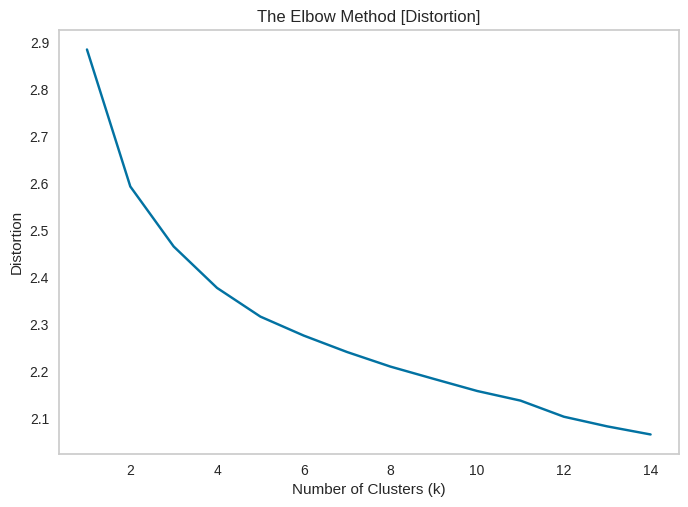

In [ ]:
plt.plot(range(1, 15), distortions, "bx-")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Distortion")
plt.title("The Elbow Method [Distortion]")
plt.grid()
plt.show()

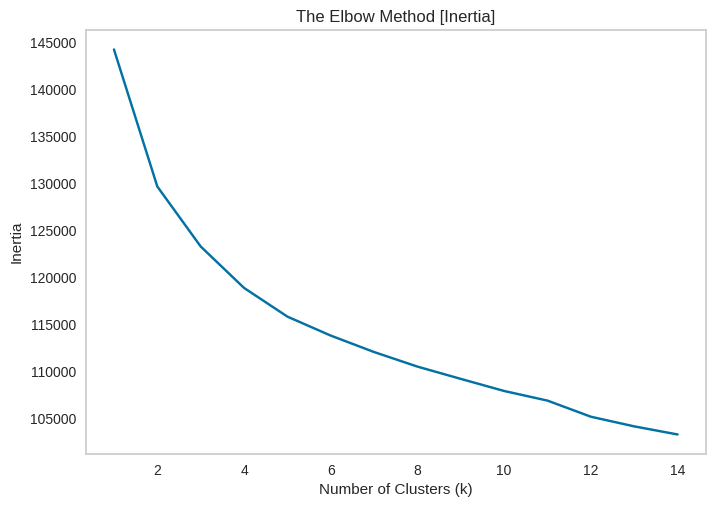

In [ ]:
plt.plot(range(1, 15), inertias, "bx-")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("The Elbow Method [Inertia]")
plt.grid()
plt.show()

Из графиков следует, что оптимальным числом кластеров можно считать k = 3, 4, 5. 

## Реализация K-Means

In [ ]:
def dist(x, y):
    return np.linalg.norm(x - y)


def find_centroid(cluster):
    if len(cluster) == 0:
        return None

    return np.mean(cluster, axis=0)


def my_kmeans(k: int, df: pd.DataFrame, max_iter: int = 100, tol: float = 0.0001):
    centroids = df.sample(n=k).to_numpy()

    for _ in range(max_iter):
        clusters = {i: [] for i in range(k)}

        for _, row in df.iterrows():
            point = row.to_numpy()

            distances = [dist(point, centroid) for centroid in centroids]
            cluster_id = np.argmin(distances)
            clusters[cluster_id].append(point)

        new_centroids = []

        for i in range(k):
            if clusters[i]:
                new_centroids.append(find_centroid(clusters[i]))
            else:
                new_centroids.append(centroids[i])

        new_centroids = np.array(new_centroids)

        if np.allclose(centroids, new_centroids, atol=tol):
            return clusters, new_centroids
        else:
            centroids = new_centroids

Теперь сравненим реализацию из sklearn с написанной выше. 

In [101]:
k = 5
test_df = df[:500]

kmeans = KMeans(n_clusters=k, random_state=42, max_iter=100, tol=0.0001).fit(test_df)
centroids_sk = kmeans.cluster_centers_
_, centroids_my = my_kmeans(k, test_df)

distortion_sk = (
    sum(np.min(distance.cdist(test_df, centroids_sk, "euclidean"), axis=1) ** 2)
    / test_df.shape[0]
)
distortion_my = (
    sum(np.min(distance.cdist(test_df, centroids_my, "euclidean"), axis=1) ** 2)
    / test_df.shape[0]
)

labels_sk = kmeans.labels_
labels_my = np.empty(len(test_df), dtype=int)

for i, point in enumerate(test_df.to_numpy()):
    distances = [np.linalg.norm(point - centroid) for centroid in centroids_my]
    labels_my[i] = np.argmin(distances)

inertia_my = np.sum(
    [
        np.linalg.norm(point - centroids_my[labels_my[i]]) ** 2
        for i, point in enumerate(test_df.to_numpy())
    ]
)
inertia_sk = kmeans.inertia_

silhouette_sk = silhouette_score(test_df, labels_sk)
silhouette_my = silhouette_score(test_df, labels_my)

print(distortion_sk, distortion_my)
print(silhouette_sk, silhouette_my)
print(inertia_sk, inertia_my)

2.1740294620550262 2.187553809255689
0.05769549308646639 0.0579853201463469
1087.0147310275127 1093.7769046278445


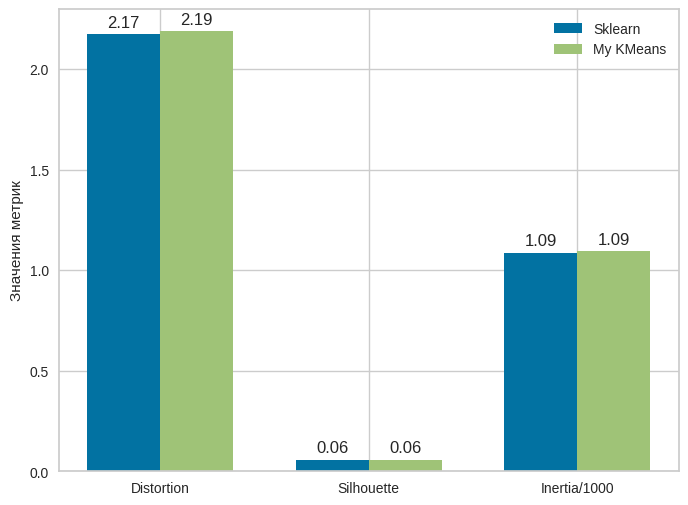

In [ ]:
metrics = ["Distortion", "Silhouette", "Inertia/1000"]

sk_values = [distortion_sk, silhouette_sk, inertia_sk / 1000]
my_values = [distortion_my, silhouette_my, inertia_my / 1000]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width / 2, sk_values, width, label="Sklearn")
rects2 = ax.bar(x + width / 2, my_values, width, label="My KMeans")

ax.set_ylabel("Значения метрик")
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(
            f"{height:.2f}",
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 3),
            textcoords="offset points",
            ha="center",
            va="bottom",
        )


autolabel(rects1)
autolabel(rects2)

plt.show()


По результатам сравнения видно, что при однинаковых начальных параметрах, реализация из sklearn справляется с поставленной задачей примерно так же хорошо, как наша собственная реализация. Теперь оценим время выполнения.